In [ ]:
# step1_setup.py
import os
import cv2
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as TF
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
# step0_mount_drive.py
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your dataset folder
data_dir = "/content/drive/MyDrive/Moon Kaggle Images"

train_dir = f"{data_dir}/Training"
test_dir  = f"{data_dir}/Testing"

print("✅ Training images path:", train_dir)
print("✅ Testing images path:", test_dir)


Mounted at /content/drive
✅ Training images path: /content/drive/MyDrive/Moon Kaggle Images/Training
✅ Testing images path: /content/drive/MyDrive/Moon Kaggle Images/Testing


In [ ]:
# step2_dataset.py
from PIL import Image
from glob import glob
import random

class MoonDataset(Dataset):
    def __init__(self, folder, scale=5, patch_size=128):
        self.files = glob(os.path.join(folder, "*"))
        self.scale = scale
        self.patch_size = patch_size
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")

        # Crop patch
        w, h = img.size
        x = random.randint(0, w - self.patch_size)
        y = random.randint(0, h - self.patch_size)
        hr = img.crop((x, y, x + self.patch_size, y + self.patch_size))

        # Simulate low-res (5m)
        lr = hr.resize((self.patch_size // self.scale, self.patch_size // self.scale), Image.BICUBIC)
        lr_up = lr.resize((self.patch_size, self.patch_size), Image.BICUBIC)

        return self.to_tensor(lr_up), self.to_tensor(hr)


In [ ]:
# ===== Step 3: Model (simple SRCNN-like) =====
# Save this as step3_model.py or run as a notebook cell after you ran Step 1 & Step 2.

import torch
import torch.nn as nn

# Device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Simple SRCNN-like model (very small / easy to train)
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # conv1: large receptive field
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU(inplace=True)
        # conv2: non-linear transform
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        # conv3: reconstruct RGB image
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x

# Helpers: save and load
def save_model(model, path="superres_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Saved model to {path}")

def load_model(path="superres_model.pth"):
    model = SRCNN().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"Loaded model from {path}")
    return model

# Quick smoke test: instantiate model and forward a dummy tensor
if __name__ == "__main__":   # If you run this file directly
    model = SRCNN().to(device)
    dummy = torch.randn(1, 3, 128, 128).to(device)   # batch x C x H x W
    out = model(dummy)
    print("Input shape:", dummy.shape, "Output shape:", out.shape)


Using device: cuda
Input shape: torch.Size([1, 3, 128, 128]) Output shape: torch.Size([1, 3, 128, 128])


In [ ]:
# ===== Step 4: Training & Evaluation =====
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Make sure you already ran: drive mount + dataset + model cells
# (train_dir and test_dir must already be defined)

# Reuse classes
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Create dataloaders
train_data = MoonDataset(train_dir)
test_data = MoonDataset(test_dir)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1)

# Train for a few epochs (you can increase)
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        optimizer.zero_grad()
        sr_imgs = model(lr_imgs)
        loss = criterion(sr_imgs, hr_imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

# Save model
save_model(model, "superres_model.pth")

# --- Evaluation ---
model.eval()
mse_total, psnr_total = 0, 0
for lr_imgs, hr_imgs in test_loader:
    lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
    with torch.no_grad():
        sr_imgs = model(lr_imgs)
    mse = ((sr_imgs - hr_imgs) ** 2).mean().item()
    psnr = 10 * np.log10(1 / mse)
    mse_total += mse
    psnr_total += psnr

print(f"\nAverage PSNR on Test Set: {psnr_total / len(test_loader):.2f} dB")


Epoch 1/5: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]


Epoch [1/5] Loss: 0.0799


Epoch 2/5: 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]


Epoch [2/5] Loss: 0.0284


Epoch 3/5: 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


Epoch [3/5] Loss: 0.0112


Epoch 4/5: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


Epoch [4/5] Loss: 0.0077


Epoch 5/5: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


Epoch [5/5] Loss: 0.0076
Saved model to superres_model.pth

Average PSNR on Test Set: 24.82 dB


Loaded model from superres_model.pth


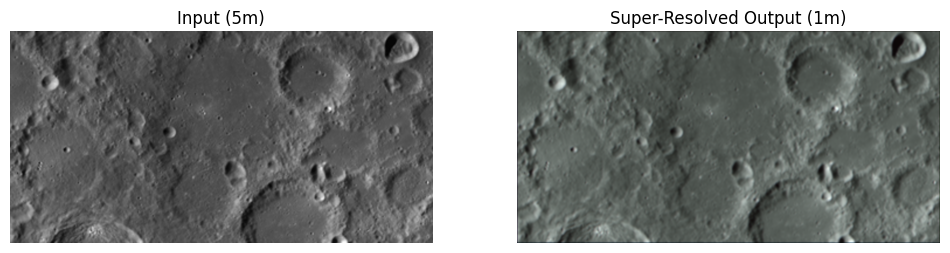

✅ 1m super-resolved image saved to: Results_SR/download.png


In [ ]:
# ===== Step 5: Super-Resolve (5m → 1m) =====
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import os

# Load trained model
model = load_model("superres_model.pth")
model.eval()

def super_resolve_image(image_path, scale=5, save_dir="Results_SR"):
    """
    Upscales a 5m image to 1m using the trained super-resolution model.
    Saves the 1m output to /Results_SR in Drive.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Read the image
    img = Image.open(image_path).convert("RGB")

    # Simulate low-resolution input (5 m)
    lr = img.resize((img.width // scale, img.height // scale), Image.BICUBIC)
    lr_up = lr.resize(img.size, Image.BICUBIC)

    # Prepare tensor
    input_tensor = transforms.ToTensor()(lr_up).unsqueeze(0).to(device)

    # Run model
    with torch.no_grad():
        sr = model(input_tensor).squeeze().permute(1, 2, 0).cpu().numpy()

    sr_img = np.clip(sr * 255, 0, 255).astype(np.uint8)

    # Save result
    out_path = os.path.join(save_dir, os.path.basename(image_path))
    Image.fromarray(sr_img).save(out_path)

    # Show comparison
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input (5m)")
    plt.imshow(lr_up)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Super-Resolved Output (1m)")
    plt.imshow(sr_img)
    plt.axis("off")
    plt.show()

    print(f"✅ 1m super-resolved image saved to: {out_path}")
    return sr_img, out_path


# 🔹 Example usage: pick one file from your Testing folder
example_img = os.path.join(test_dir, os.listdir(test_dir)[0])
sr_img, sr_path = super_resolve_image(example_img, scale=5)


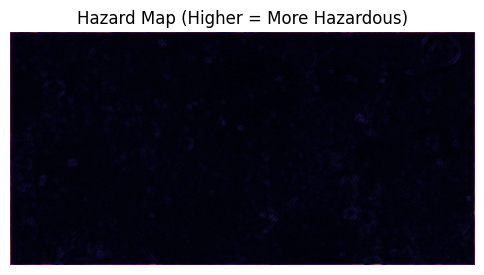

✅ Hazard map saved to: Results_Hazard/hazard_map.png


In [ ]:
# ===== Step 6: Hazard Map Generation =====
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def generate_hazard_map(sr_img, save_dir="Results_Hazard"):
    """
    Generates a hazard map from a 1m super-resolved image
    using edge and roughness analysis.
    Saves the hazard map to /Results_Hazard.
    """
    os.makedirs(save_dir, exist_ok=True)

    gray = cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY)

    # Edge and roughness features
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=3)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F)

    # Combine and normalize
    hazard = np.abs(sobel) + np.abs(lap_var)
    hazard = (hazard - hazard.min()) / (hazard.max() - hazard.min())

    # Save hazard map
    hazard_uint8 = (hazard * 255).astype(np.uint8)
    out_path = os.path.join(save_dir, "hazard_map.png")
    cv2.imwrite(out_path, hazard_uint8)

    # Display
    plt.figure(figsize=(6, 6))
    plt.title("Hazard Map (Higher = More Hazardous)")
    plt.imshow(hazard, cmap="inferno")
    plt.axis("off")
    plt.show()

    print(f"✅ Hazard map saved to: {out_path}")
    return hazard, out_path


# 🔹 Example usage (uses Step 5 output)
hazard, hazard_path = generate_hazard_map(sr_img)


Found 4 testing images in Drive folder.

🔹 [1/4] Processing: download.png


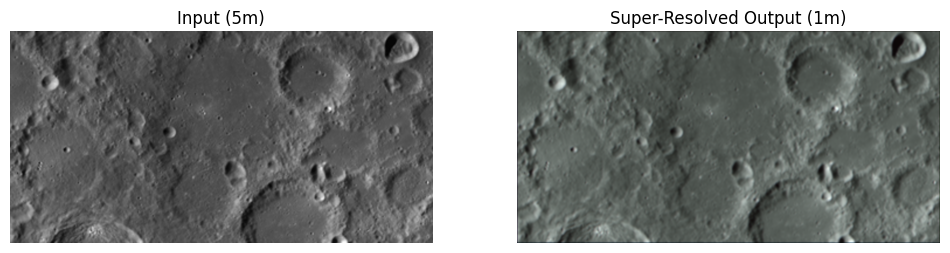

✅ 1m super-resolved image saved to: Results_SR/download.png


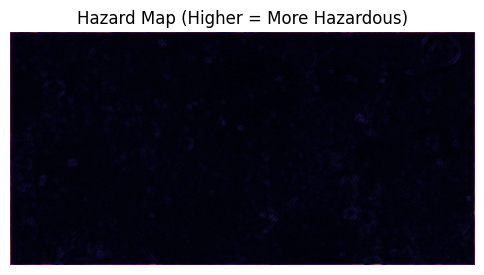

✅ Hazard map saved to: Results_Hazard/hazard_map.png
✅ Done: download.png
   1 m image saved → Results_SR/download.png
   Hazard map saved → Results_Hazard/hazard_map.png

🔹 [2/4] Processing: download (1).png


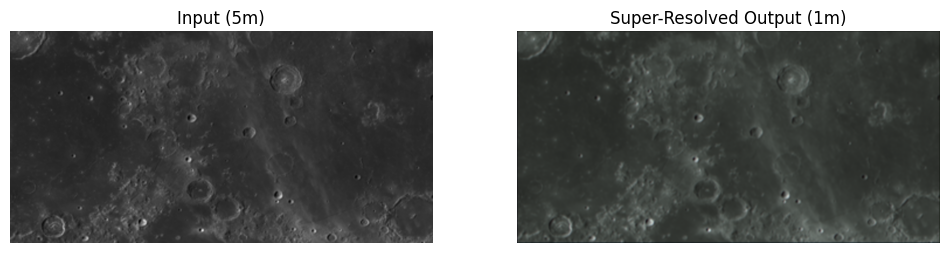

✅ 1m super-resolved image saved to: Results_SR/download (1).png


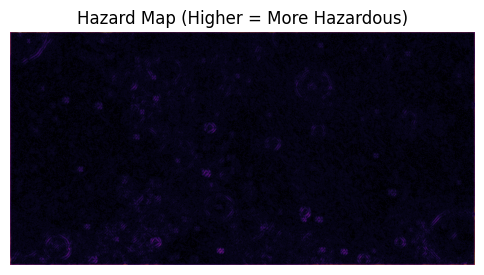

✅ Hazard map saved to: Results_Hazard/hazard_map.png
✅ Done: download (1).png
   1 m image saved → Results_SR/download (1).png
   Hazard map saved → Results_Hazard/hazard_map.png

🔹 [3/4] Processing: download (2).png


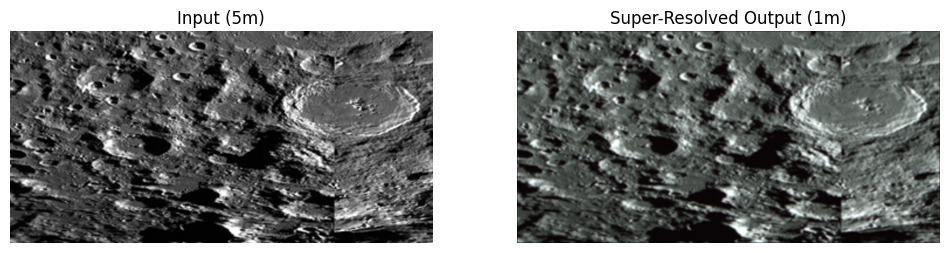

✅ 1m super-resolved image saved to: Results_SR/download (2).png


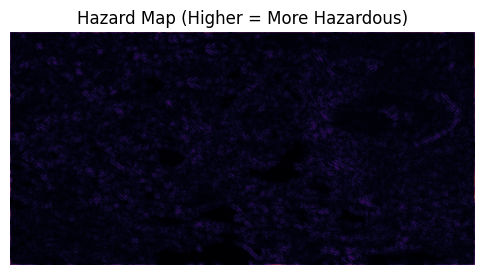

✅ Hazard map saved to: Results_Hazard/hazard_map.png
✅ Done: download (2).png
   1 m image saved → Results_SR/download (2).png
   Hazard map saved → Results_Hazard/hazard_map.png

🔹 [4/4] Processing: download (3).png


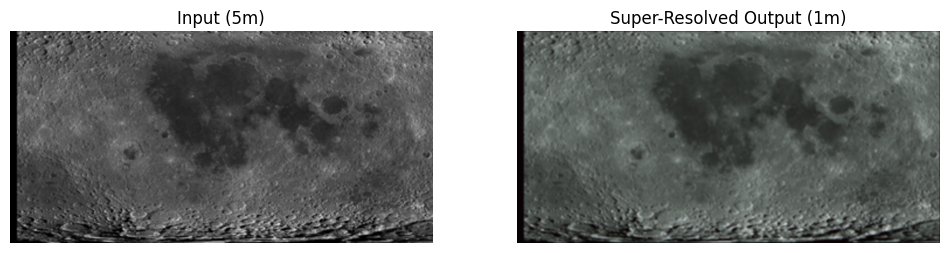

✅ 1m super-resolved image saved to: Results_SR/download (3).png


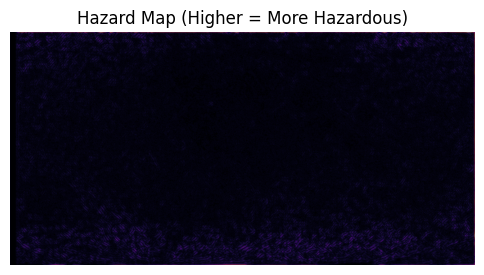

✅ Hazard map saved to: Results_Hazard/hazard_map.png
✅ Done: download (3).png
   1 m image saved → Results_SR/download (3).png
   Hazard map saved → Results_Hazard/hazard_map.png

🎯 Batch processing complete! All results saved in Drive folders.


In [ ]:
# ===== Step 7: Batch Processing for All Testing Images =====
import os

# Ensure output folders exist
os.makedirs("Results_SR", exist_ok=True)
os.makedirs("Results_Hazard", exist_ok=True)

# List all image files in the testing folder
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

print(f"Found {len(test_images)} testing images in Drive folder.\n")

# Loop through each test image
for i, img_name in enumerate(test_images, 1):
    img_path = os.path.join(test_dir, img_name)
    print(f"🔹 [{i}/{len(test_images)}] Processing: {img_name}")

    try:
        # Step 5 → Super-resolve (5 m → 1 m)
        sr_img, sr_path = super_resolve_image(img_path, scale=5)

        # Step 6 → Generate hazard map
        hazard, hazard_path = generate_hazard_map(sr_img)

        print(f"✅ Done: {img_name}")
        print(f"   1 m image saved → {sr_path}")
        print(f"   Hazard map saved → {hazard_path}\n")

    except Exception as e:
        print(f"❌ Error processing {img_name}: {e}\n")

print("🎯 Batch processing complete! All results saved in Drive folders.")
